In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

In [2]:
from tqdm import tqdm

In [3]:
def read_ubyte(file_path,b,a=0,type="int"):
    with open(file_path, 'rb') as f:
        data = f.read()
    if type=="int":
        return int.from_bytes(data[a:b], byteorder='big')
    return data[a:b]

In [4]:
num_images=60000
imagedim=28

In [5]:
data=read_ubyte('/home/user456/CommonRuntime/python ML/data/archive(1)/train-images.idx3-ubyte',b=None,type=None)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

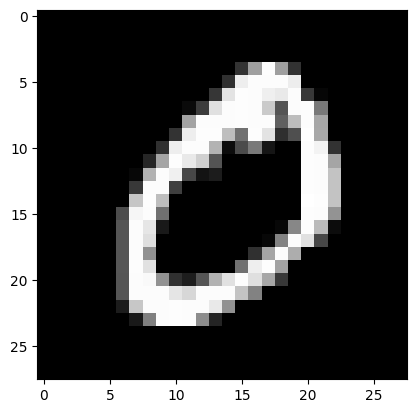

In [6]:
a=np.frombuffer(data, dtype=np.uint8, offset=16)
a=a.reshape(-1,28,28)
print(a[0])
plt.imshow(a[1], cmap='gray')
plt.show()



In [7]:
labels=read_ubyte('/home/user456/CommonRuntime/python ML/data/archive(1)/train-labels.idx1-ubyte',b=None,type=None)
b=np.frombuffer(labels, dtype=np.uint8, offset=8)
print(b.shape)

(60000,)


In [8]:
b=b.reshape(-1,1)
print(b.shape)

(60000, 1)


In [9]:
xy=np.concatenate([a.reshape(-1,784),b],axis=1)
print(xy.shape)

(60000, 785)


In [10]:
class Imageset(Dataset):
    def __init__(self,xy):
        super().__init__()
        self.xy=xy
    def __getitem__(self, index):
        z=self.xy[index]
        return (z[:784]/255).to(torch.float32),z[784].to(torch.long)
    def __len__(self):
        return self.xy.shape[0]

In [11]:
fdata=Imageset(torch.from_numpy(xy))
floaded=DataLoader(fdata,batch_size=64,shuffle=True)
for i,(x,y) in enumerate(floaded):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 784])
torch.Size([64])


In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(784,128)
        self.layer2=nn.LeakyReLU()
        self.layer3=nn.Linear(128,32)
        self.layer4=nn.ReLU()
        self.layer5=nn.Linear(32,10)
    def forward(self,a):
        x=self.layer1(a)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return x

In [14]:
model=Model()
model=model.to(device)


In [15]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
loss=nn.CrossEntropyLoss()


In [16]:
for i in range(1,60000):
    tot_loss=0
    for _,(inp,out) in tqdm(enumerate(floaded),total=len(floaded),desc=f'Epoch {i}'):
        inp=inp.to(device)
        out=out.to(device)
        y_pred=model(inp)
        lossy=loss(y_pred,out)
        tot_loss+=lossy.item()
        optimizer.zero_grad()
        lossy.backward()
        optimizer.step()
    print(f'Epoch {i} has a loss of {tot_loss}')

Epoch 1: 100%|██████████| 938/938 [00:03<00:00, 266.35it/s]


Epoch 1 has a loss of 339.929672524333


Epoch 2: 100%|██████████| 938/938 [00:03<00:00, 278.00it/s]


Epoch 2 has a loss of 146.74776699766517


Epoch 3:  10%|█         | 98/938 [00:00<00:03, 257.12it/s]


KeyboardInterrupt: 

In [18]:
with torch.no_grad():
    sample=torch.from_numpy(a[0].reshape(-1,784)/255).to(torch.float32).to(device)
    pred=model(sample)
    print(torch.argmax(pred,dim=1).item())  

5
